In [1]:
import torch
import torch.nn as nn
import yaml
import h5py
from utils import TransformerOperatorDataset
import torch.nn.functional as F
from tqdm import tqdm
import math
import time
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
import os
import shutil

from models.pitt import PhysicsInformedTokenTransformer
from models.pitt import StandardPhysicsInformedTokenTransformer

from models.oformer import Encoder1D, STDecoder1D, OFormer1D, PointWiseDecoder1D
from models.fno import FNO1d
from models.deeponet import DeepONet1D

import sys

Using backend: pytorch
Other supported backends: tensorflow.compat.v1, tensorflow, jax, paddle.
paddle supports more examples now and is recommended.


No backend selected.
Finding available backend...
Found pytorch
Setting the default backend to "pytorch". You can change it in the ~/.deepxde/config.json file or export the DDE_BACKEND environment variable. Valid options are: tensorflow.compat.v1, tensorflow, pytorch, jax, paddle (all lowercase)


In [2]:
device = 'cuda' if(torch.cuda.is_available()) else 'cpu'

In [27]:
def evaluate(test_loader, transformer, loss_fn):
    #src_mask = generate_square_subsequent_mask(640).cuda()
    with torch.no_grad():
        transformer.eval()
        test_loss = 0
        for bn, (x0, y, grid, tokens, t) in enumerate(test_loader):
        #for bn, (x, y, grid, tokens, x0) in enumerate(test_loader):
            # Forward pass: compute predictions by passing the input sequence
            # through the transformer.
            #y_pred = transformer(grid, tokens.cuda(), x0)
            y_pred = transformer(grid.to(device=device), tokens.to(device=device), x0.to(device=device), t.to(device=device))
            #y_pred = transformer(grid.to(device=device), x0.to(device=device), x0.to(device=device), t.to(device=device))
            #y_pred = transformer(grid.cuda(), tokens.cuda(), x0.cuda())#, src_mask)#[:,0,:]
            y = y[...,0].to(device=device)
    
            # Compute the loss.
            test_loss += loss_fn(y_pred, y).item()

    return test_loss/(bn+1)
    
def get_transformer(model_name, neural_operator, config):
    if(config['embedding'] == 'standard'):
        print("\nUSING STANDARD EMBEDDING")
        transformer = StandardPhysicsInformedTokenTransformer(500, config['hidden'], config['layers'], config['heads'],
                                    config['num_x'], dropout=config['dropout'], neural_operator=neural_operator).to(device=device)
    elif(config['embedding'] == 'novel'):
        print("\nUSING NOVEL EMBEDDING")
        transformer = PhysicsInformedTokenTransformer(500, config['hidden'], config['layers'], config['heads'],
                                    config['num_x'], dropout=config['dropout'], neural_operator=neural_operator).to(device=device)
    return transformer


def get_data(f, config):
    train_data = TransformerOperatorDataset(f, config['flnm'],
                            split="train",
                            initial_step=config['initial_step'],
                            reduced_resolution=config['reduced_resolution'],
                            reduced_resolution_t=config['reduced_resolution_t'],
                            reduced_batch=config['reduced_batch'],
                            saved_folder=config['base_path'],
                            return_text=config['return_text'],
                            num_t=config['num_t'],
                            num_x=config['num_x'],
                            sim_time=config['sim_time'],
                            num_samples=config['num_samples'],
                            train_style=config['train_style'],
                            rollout_length=config['rollout_length'],
                            seed=config['seed'],
    )
    train_data.data = train_data.data.to(device)
    train_data.grid = train_data.grid.to(device)
    val_data = TransformerOperatorDataset(f, config['flnm'],
                            split="val",
                            initial_step=config['initial_step'],
                            reduced_resolution=config['reduced_resolution'],
                            reduced_resolution_t=config['reduced_resolution_t'],
                            reduced_batch=config['reduced_batch'],
                            saved_folder=config['base_path'],
                            return_text=config['return_text'],
                            num_t=config['num_t'],
                            num_x=config['num_x'],
                            sim_time=config['sim_time'],
                            num_samples=config['num_samples'],
                            train_style=config['train_style'],
                            rollout_length=config['rollout_length'],
                            seed=config['seed'],
    )
    val_data.data = val_data.data.to(device)
    val_data.grid = val_data.grid.to(device)
    test_data = TransformerOperatorDataset(f, config['flnm'],
                            split="test",
                            initial_step=config['initial_step'],
                            reduced_resolution=config['reduced_resolution'],
                            reduced_resolution_t=config['reduced_resolution_t'],
                            reduced_batch=config['reduced_batch'],
                            saved_folder=config['base_path'],
                            return_text=config['return_text'],
                            num_t=config['num_t'],
                            num_x=config['num_x'],
                            sim_time=config['sim_time'],
                            num_samples=config['num_samples'],
                            train_style=config['train_style'],
                            rollout_length=config['rollout_length'],
                            seed=config['seed'], 
    )
    test_data.data = test_data.data.to(device)
    test_data.grid = test_data.grid.to(device)

    train_loader = torch.utils.data.DataLoader(train_data, batch_size=config['batch_size'],
                                               num_workers=config['num_workers'], shuffle=True,
                                               generator=torch.Generator(device='cuda'))
    val_loader = torch.utils.data.DataLoader(val_data, batch_size=config['batch_size'],
                                             num_workers=config['num_workers'], shuffle=False,
                                             generator=torch.Generator(device='cuda'))
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=config['batch_size'],
                                             num_workers=config['num_workers'], shuffle=False,
                                             generator=torch.Generator(device='cuda'))

    # Check against data leaks
    assert not (bool(set(train_data.data_list) & \
                     set(val_data.data_list)) | \
                bool(set(train_data.data_list) & \
                     set(test_data.data_list)) & \
                bool(set(val_data.data_list) & \
                     set(test_data.data_list)))

    return train_loader, val_loader, test_loader
    
def get_neural_operator(model_name, config):
    if(model_name == "fno"):
        neural_operator = FNO1d(config['num_channels'], config['modes'], config['width'], config['initial_step'], config['dropout'])
    elif(model_name == "deeponet"):
        neural_operator = DeepONet1D(layer_sizes_branch=config['branch_net'], layer_sizes_trunk=config['trunk_net'],
                                 activation=config['activation'],
                                 kernel_initializer=config['kernel_initializer'])
    elif(model_name == "oformer"):
        encoder = Encoder1D(input_channels=config['input_channels'], in_emb_dim=config['in_emb_dim'],
                            out_seq_emb_dim=config['out_seq_emb_dim'], depth=config['depth'], dropout=config['dropout'],
                            res=config['enc_res'])
        decoder = PointWiseDecoder1D(latent_channels=config['latent_channels'], out_channels=config['out_channels'],
                                     decoding_depth=config['decoding_depth'], scale=config['scale'], res=config['dec_res'])
        neural_operator = OFormer1D(encoder, decoder)
    
    neural_operator.to(device)
    return neural_operator


In [22]:
with open("./configs/pitt_config.yaml", 'r') as stream:
    config = yaml.safe_load(stream)
train_args = config['args']
prefix = train_args['flnm'] + "_" + train_args['data_name'].split("_")[0] + "_" + train_args['train_style'] + "_" + \
         train_args['embedding']
train_args['prefix'] = prefix
train_args['seed'] = 2

In [24]:
path = "{}{}_{}_{}".format(train_args['results_dir'], train_args['transformer'], train_args['neural_operator'], prefix)
f = h5py.File("{}{}".format(train_args['base_path'], train_args['data_name']), 'r')
model_name = train_args['flnm'] + '_{}'.format(train_args['transformer']) + "_{}.pt".format(train_args['seed'])
model_path = path + "/" + model_name

In [25]:
train_loader, val_loader, test_loader = get_data(f, train_args)


SEED: 2
Gathering data...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 440.88it/s]



NUMBER OF SAMPLES: 540
Processing data...


540it [00:00, 690.15it/s]
/home/oliver/code/PhysicsInformedTokenTransformer/utils.py:475: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1729647378361/work/torch/csrc/utils/tensor_new.cpp:278.)
  self.time = torch.Tensor(self.time).to(device=device)



SEED: 2
Gathering data...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 675.36it/s]



NUMBER OF SAMPLES: 180
Processing data...


180it [00:00, 733.17it/s]



SEED: 2
Gathering data...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 736.23it/s]



NUMBER OF SAMPLES: 180
Processing data...


180it [00:00, 728.22it/s]


In [30]:
neural_operator = get_neural_operator(train_args['neural_operator'], train_args)
transformer = get_transformer(train_args['transformer'], neural_operator, train_args)


USING NOVEL EMBEDDING


In [32]:
train_args

{'if_training': True,
 'results_dir': './1D_results/',
 'train_style': 'next_step',
 'transformer': 'pitt',
 'neural_operator': 'fno',
 'embedding': 'novel',
 'base_path': './pde_data/',
 'continue_training': False,
 'forcing': False,
 'rollout_length': 1,
 'num_workers': 0,
 'batch_size': 128,
 'initial_step': 10,
 't_train': 200,
 'model_update': 1,
 'flnm': 'Heat',
 'data_name': 'heat_1000.h5',
 'fno': False,
 'return_text': True,
 'reduced_resolution': 1,
 'reduced_resolution_t': 1,
 'reduced_batch': 1,
 'epochs': 200,
 'num_seeds': 5,
 'learning_rate': 0.001,
 'weight_decay': 1e-05,
 'scheduler_step': 200,
 'scheduler_gamma': 0.1,
 'training_type': 'single',
 'num_x': 100,
 'num_t': 100,
 'sim_time': 1000,
 'num_samples': 10,
 'hidden': 64,
 'layers': 1,
 'heads': 1,
 'dropout': 0.05,
 'log_freq': 1,
 'progress_plot_freq': 10,
 'width': 64,
 'modes': 4,
 'num_channels': 1,
 'input_channels': 10,
 'in_emb_dim': 64,
 'out_seq_emb_dim': 64,
 'depth': 2,
 'enc_res': 64,
 'latent_chann

In [33]:
transformer.load_state_dict(torch.load(model_path)['model_state_dict'])

/tmp/ipykernel_2650501/2077529672.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  transformer.load_state_dict(torch.load(model_path)['model_state_dict'])


<All keys matched successfully>

In [34]:
loss_fn = nn.L1Loss(reduction='mean')

In [35]:
test_value = evaluate(test_loader, transformer, loss_fn)

/home/oliver/miniconda3/envs/pitt/lib/python3.12/site-packages/torch/nn/modules/instancenorm.py:115: UserWarning: input's size at dim=1 does not match num_features. You can silence this warning by not passing in num_features, which is not used because affine=False
  warnings.warn(


In [36]:
test_value

0.004460181458853185

In [37]:
with torch.no_grad():
    transformer.eval()
    test_loss = 0

In [50]:
enumerate(test_loader)

In [107]:
(x0, y, grid, tokens, t) = list(test_loader)[0]

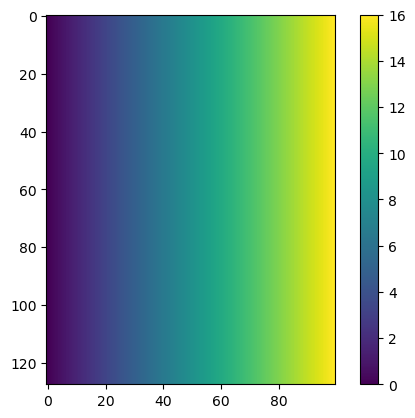

In [108]:
plt.imshow(grid.cpu())
plt.colorbar()

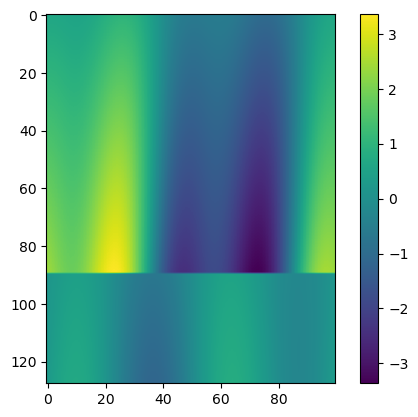

In [109]:
plt.imshow((y.cpu())[:,:,0])
plt.colorbar()

In [110]:
y.shape

torch.Size([128, 100, 1])

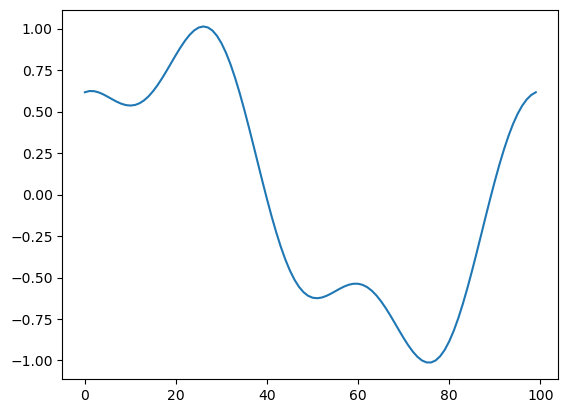

In [115]:
plt.plot((y[0,:,0]).cpu())

In [164]:
t=t*0-0.1

In [165]:
t

tensor([-0.1000, -0.1000, -0.1000, -0.1000, -0.1000, -0.1000, -0.1000, -0.1000,
        -0.1000, -0.1000, -0.1000, -0.1000, -0.1000, -0.1000, -0.1000, -0.1000,
        -0.1000, -0.1000, -0.1000, -0.1000, -0.1000, -0.1000, -0.1000, -0.1000,
        -0.1000, -0.1000, -0.1000, -0.1000, -0.1000, -0.1000, -0.1000, -0.1000,
        -0.1000, -0.1000, -0.1000, -0.1000, -0.1000, -0.1000, -0.1000, -0.1000,
        -0.1000, -0.1000, -0.1000, -0.1000, -0.1000, -0.1000, -0.1000, -0.1000,
        -0.1000, -0.1000, -0.1000, -0.1000, -0.1000, -0.1000, -0.1000, -0.1000,
        -0.1000, -0.1000, -0.1000, -0.1000, -0.1000, -0.1000, -0.1000, -0.1000,
        -0.1000, -0.1000, -0.1000, -0.1000, -0.1000, -0.1000, -0.1000, -0.1000,
        -0.1000, -0.1000, -0.1000, -0.1000, -0.1000, -0.1000, -0.1000, -0.1000,
        -0.1000, -0.1000, -0.1000, -0.1000, -0.1000, -0.1000, -0.1000, -0.1000,
        -0.1000, -0.1000, -0.1000, -0.1000, -0.1000, -0.1000, -0.1000, -0.1000,
        -0.1000, -0.1000, -0.1000, -0.10

In [166]:
y_pred=transformer(grid.to(device=device), tokens.to(device=device), x0.to(device=device), t.to(device=device))

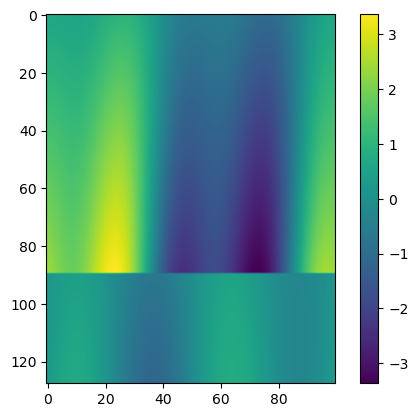

In [167]:
plt.imshow((y_pred.detach().cpu())[:,:])
plt.colorbar()

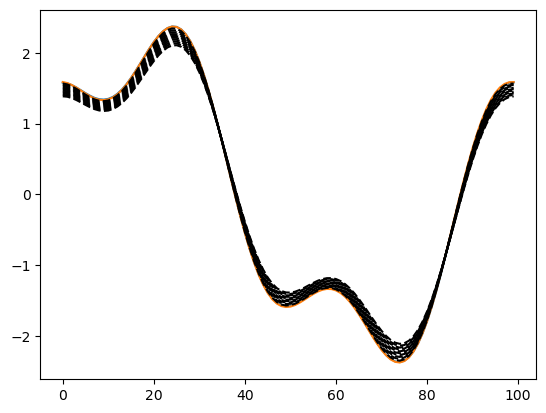

In [168]:
plt.plot(((y_pred.detach()[50,:])).cpu())
plt.plot((y[50,:,0]).cpu())
plt.plot(((x0[50,:,:]).transpose(0,1)).cpu(),'k--')

In [132]:
x0.shape

torch.Size([128, 10, 100])

In [96]:
y = y[...,0].to(device=device)    
# Compute the loss.
loss_fn(y_pred, y).item()

0.002803388750180602

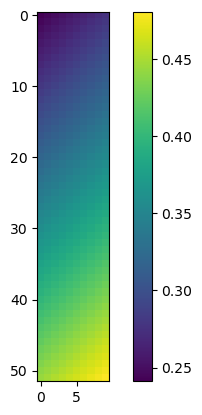

In [104]:
plt.imshow((x0[:,:,99]).cpu())
plt.colorbar()

In [105]:
train_args['batch_size']

128

In [106]:
train_args['num_workers']

0

In [169]:
train_loader.dataset.sim_time

1000